In [2]:
import wandb
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d

# 初始化wandb API
api = wandb.Api()



In [10]:
run_dict = {
    "Ours": "compare/runs/n3x9vux0",
    "PPO-lag" : "dreamer3/runs/laejq4nf",
    "DreamerV3" : "compare/runs/utjmmypx",
    "EZ" :"compare/runs/xf09r2v9"

}

def get_run_data(run_id):
    run = api.run(f"gaochengzhi1999/{run_id}")
    history = run.scan_history(keys=['mean_speed', 'navigation', 'total_reward'],  max_step=800,page_size=800)
    df = pd.DataFrame(history)
    return df.head(800)  # 只取前800步

# 获取所有run的数据
run_data = {}
for name, run_id in run_dict.items():
    run_data[name] = get_run_data(run_id)


/tmp/ipykernel_4853/1602557152.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_4853/1602557152.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_4853/1602557152.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('multi-metrics.pdf', format='pdf', dpi=600)
/tmp/ipykernel_4853/1602557152.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('multi-metrics.pdf', format='pdf', dpi=600)
/tmp/ipykernel_4853/1602557152.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become

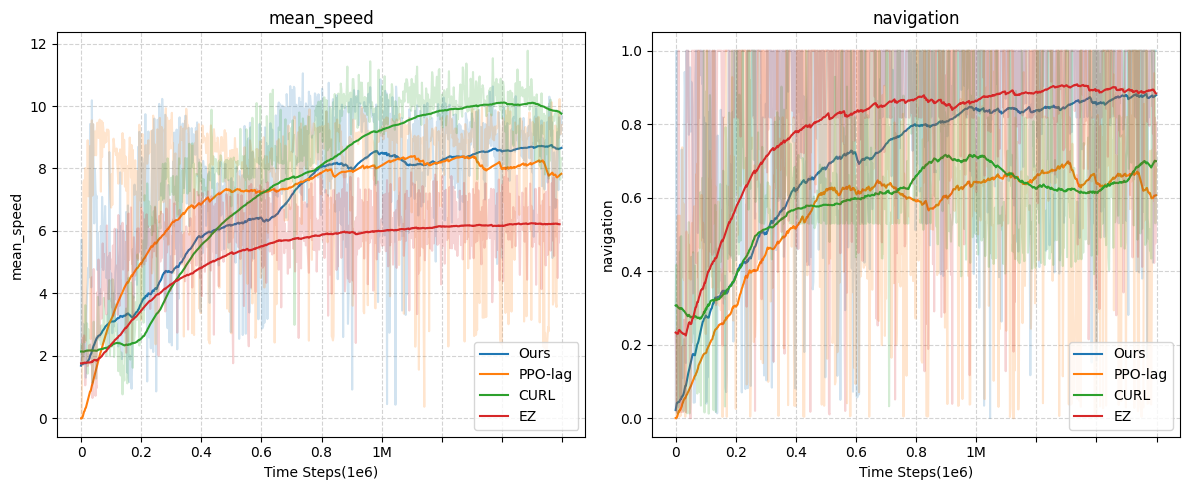

In [4]:
from scipy import stats
def remove_outliers(data, n_std=3):
    """使用z-score方法移除极端值"""
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < n_std)
    return data[filtered_entries]

def calculate_ema(data, alpha=0.99):
    """计算指数移动平均"""
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * ema[i-1] + (1 - alpha) * data[i]
    return ema

def plot_metrics(metrics, run_data, n_std=4, alpha=0.99):
    # 创建子图网格
    n_metrics = len(metrics)
    n_rows = (n_metrics + 1) // 2  # 向上取整
    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 5*n_rows))
    axs = axs.ravel()  # 将二维数组展平便于索引
    
    # 为每个算法创建颜色映射
    algorithms = list(run_data.keys())
    color_map = {alg: plt.cm.tab10(i) for i, alg in enumerate(algorithms)}
    
    # 遍历每个指标
    for i, metric in enumerate(metrics):
        ax = axs[i]
        
        # 存储当前指标的算法标签
        metric_handles = []
        metric_labels = []
        
        for run_name, df in run_data.items():
            y = df[metric].values
            x = np.arange(len(y))
            
            # 数据预处理
            valid_mask = ~np.isnan(y)
            y_clean = y[valid_mask]
            x_clean = x[valid_mask]
            y_clean = remove_outliers(y_clean, n_std=n_std)
            
            # 计算平滑曲线
            y_smooth = calculate_ema(y_clean, alpha=alpha)
            
            # 特殊处理 PPO 的颜色
            color = 'orange' if run_name == "PPO" else color_map[run_name]
            
            # 绘制原始数据（半透明）和平滑曲线
            ax.plot(x_clean[:len(y_clean)], y_clean, alpha=0.2, color=color)
            line, = ax.plot(x_clean[:len(y_smooth)], y_smooth, label=run_name, color=color)
            
            metric_handles.append(line)
            metric_labels.append(run_name)
        
        # 设置子图属性
        ax.set_title(f'{metric}')
        ax.set_xlabel('Time Steps(1e6)')
        ax.set_ylabel(metric)
        ax.grid(True, linestyle='--', color='lightgrey')
        ax.legend(handles=metric_handles, labels=metric_labels, loc='lower right')
        
        # 设置x轴刻度标签
        labels = ["0", '0', '0.2', '0.4', '0.6', '0.8', '1M']
        ax.set_xticklabels(labels)
    
    # 如果指标数量为奇数，删除多余的子图
    if n_metrics % 2 == 1:
        fig.delaxes(axs[-1])
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    plt.savefig('multi-metrics.pdf', format='pdf', dpi=600)
    plt.show()

# 调用函数绘图
metrics = ['mean_speed', 'navigation']
plot_metrics(metrics, run_data)


/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)


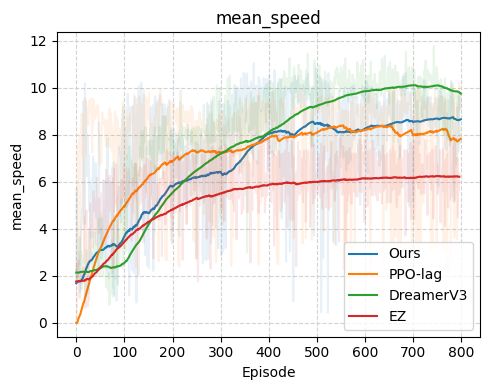

/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)


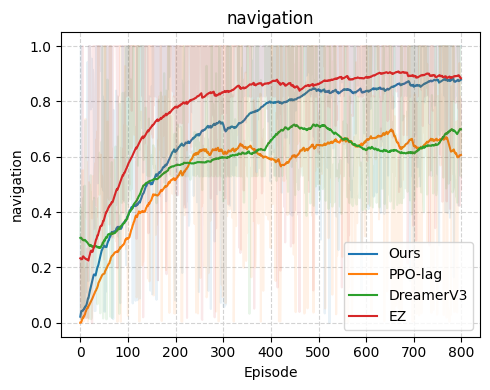

/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
/tmp/ipykernel_4853/1304101665.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)


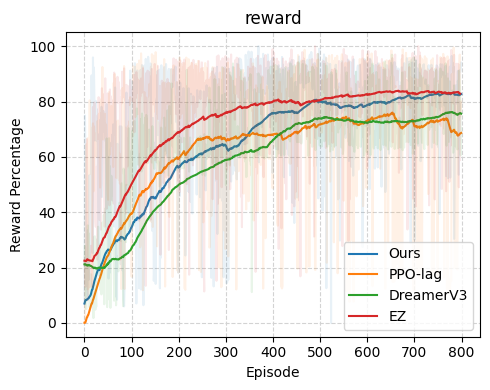

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def remove_outliers(data, n_std=3):
    """使用z-score方法移除极端值"""
    z_scores = stats.zscore(data)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < n_std)
    return data[filtered_entries]

def calculate_ema(data, alpha=0.99):
    """计算指数移动平均"""
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * ema[i-1] + (1 - alpha) * data[i]
    return ema

def calculate_reward_percentage(df, metrics):
    """计算 reward 得分，作为指标得分百分比的平均值"""
    # 计算百分比
    percentages = [(df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min() + np.finfo(float).eps) * 100 for metric in metrics]
    # 计算平均值
    averaged_percentage = np.mean(percentages, axis=0)
    return averaged_percentage

def plot_metrics(metrics, run_data, n_std=4, alpha=0.99):
    # 增加新的指标'Reward'
    all_metrics = metrics + ['reward']

    # 为每个算法创建颜色映射
    algorithms = list(run_data.keys())
    color_map = {alg: plt.cm.tab10(i) for i, alg in enumerate(algorithms)}
    
    # 遍历每个指标
    for metric in all_metrics:
        plt.figure(figsize=(5, 4))
        
        # 存储当前指标的算法标签
        metric_handles = []
        metric_labels = []
        
        for run_name, df in run_data.items():
            if metric == 'reward':
                y = calculate_reward_percentage(df, metrics)
            else:
                y = df[metric].values
            
            x = np.arange(len(y))
            
            # 数据预处理
            valid_mask = ~np.isnan(y)
            y_clean = y[valid_mask]
            x_clean = x[valid_mask]
            y_clean = remove_outliers(y_clean, n_std=n_std)
            
            # 计算平滑曲线
            y_smooth = calculate_ema(y_clean, alpha=alpha)
            
            # 特殊处理 PPO 的颜色
            color = 'orange' if run_name == "PPO" else color_map[run_name]
            
            # 绘制原始数据（半透明）和平滑曲线
            plt.plot(x_clean[:len(y_clean)], y_clean, alpha=0.1, color=color)
            line, = plt.plot(x_clean[:len(y_smooth)], y_smooth, label=run_name, color=color)
            
            metric_handles.append(line)
            metric_labels.append(run_name)
        
        # 设置图表属性
        plt.title(f'{metric}')
        plt.xlabel('Episode')
        plt.ylabel(metric if metric != 'reward' else 'Reward Percentage')
        plt.grid(True, linestyle='--', color='lightgrey')
        plt.legend(handles=metric_handles, labels=metric_labels, loc='lower right')
        
        
        # 保存单独的图片
        plt.tight_layout()
        plt.savefig(f'{metric}.pdf', format='pdf', dpi=300)
        plt.show()

# 示例调用
plot_metrics(metrics, run_data)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 加载数据
truth = np.load('truth.npy')
model = np.load('model.npy')
error = np.load('error.npy')

# 获取时间步长和维度
time_steps, dims = truth.shape

# 创建画布
fig, axes = plt.subplots(dims, 1, figsize=(10, 2 * dims), sharex=True)

# 函数：更新每一帧
def update(frame):
    for dim in range(dims):
        axes[dim].clear()
        axes[dim].plot(truth[:frame + 1, dim], label='Truth', color='blue')
        axes[dim].plot(model[:frame + 1, dim], label='Model', color='red', linestyle='--')
        axes[dim].fill_between(range(frame + 1), 
                               truth[:frame + 1, dim] - error[:frame + 1, dim], 
                               truth[:frame + 1, dim] + error[:frame + 1, dim], 
                               color='gray', alpha=0.3)
        axes[dim].set_title(f'Dimension {dim+1}')
        axes[dim].legend()

    fig.suptitle(f'Time Step: {frame+1}/{time_steps}')

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=time_steps, repeat=False)

# 显示动画
plt.tight_layout()
plt.subplots_adjust(top=0.95) # 为总标题留出空间
HTML(ani.to_jshtml())


ValueError: too many values to unpack (expected 2)

In [20]:
# 选择要绘制的样本
# 根据您的实际情况设置
max_angle = 360.0  # 最大角度，单位为度
detect_range = 1.0  # 最大检测距离

# 自车初始位置（可根据需要修改）
x_ego_init, y_ego_init = 0.0, 0.0

batch_idx = 0  # 第一个批次
sample_truth = truth[batch_idx]  # 形状：(20, 37)

# 时间步数
time_steps = sample_truth.shape[0]

# 初始化存储位置的列表
ego_positions = []  # 自车位置
other_positions = [[] for _ in range(5)]  # 五辆其他车辆的位置

# 自车位置初始化
x_ego, y_ego = x_ego_init, y_ego_init

for t in range(time_steps):
    state = sample_truth[t]  # 当前时间步的状态向量

    # 存储自车位置
    ego_positions.append((x_ego, y_ego))

    # 提取并计算其他车辆的位置
    for i in range(5):
        idx = i * 6

        # 提取归一化后的值
        angle_norm = state[idx + 1]
        distance_norm = state[idx + 4]

        # 还原实际值
        angle = angle_norm * max_angle  # 恢复角度，单位为度
        distance = distance_norm * detect_range  # 恢复距离

        # 如果距离为0，表示没有检测到车辆，跳过
        if distance == 0:
            continue

        # 计算相对位置
        angle_rad = radians(angle)  # 角度转弧度
        dx = distance * cos(angle_rad)
        dy = distance * sin(angle_rad)

        # 计算实际位置
        x_other = x_ego + dx
        y_other = y_ego + dy

        # 存储位置
        other_positions[i].append((x_other, y_other))
    # 如果有自车位置的更新逻辑，可以在这里添加
    # 例如，根据自车速度和方向更新位置


In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 选择样本索引（0 到 5）
batch_idx = 0  # 你可以修改此值

# 提取自车速度数据
ego_speed_truth = truth[batch_idx, :, 30]
ego_speed_model = model[batch_idx, :, 30]
ego_speed_error = error[batch_idx, :, 30]

# 时间步数
time_steps = np.arange(ego_speed_truth.shape[0])

# 创建 Figure 对象
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制 Truth 动画
def animate_truth(i):
    ax.clear()
    ax.set_title('自车速度（Truth）')
    ax.set_xlabel('时间步')
    ax.set_ylabel('归一化速度值')
    ax.set_ylim(-1, 1)
    ax.plot(time_steps[:i], ego_speed_truth[:i], color='blue')
    ax.grid(True)

ani_truth = animation.FuncAnimation(fig, animate_truth, frames=len(time_steps), interval=500)

# 保存为 GIF 文件
ani_truth.save('truth.gif', writer='pillow')

plt.close()
# 创建 Figure 对象
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制 Model 动画
def animate_model(i):
    ax.clear()
    ax.set_title('自车速度（Model）')
    ax.set_xlabel('时间步')
    ax.set_ylabel('归一化速度值')
    ax.set_ylim(-1, 1)
    ax.plot(time_steps[:i], ego_speed_model[:i], color='red')
    ax.grid(True)

ani_model = animation.FuncAnimation(fig, animate_model, frames=len(time_steps), interval=500)

# 保存为 GIF 文件
ani_model.save('model.gif', writer='pillow')

plt.close()
# 创建 Figure 对象
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制 Error 动画
def animate_error(i):
    ax.clear()
    ax.set_title('自车速度误差（Error）')
    ax.set_xlabel('时间步')
    ax.set_ylabel('误差值')
    ax.set_ylim(-1, 1)
    ax.plot(time_steps[:i], ego_speed_error[:i], color='green')
    ax.grid(True)

ani_error = animation.FuncAnimation(fig, animate_error, frames=len(time_steps), interval=500)

# 保存为 GIF 文件
ani_error.save('error.gif', writer='pillow')

plt.close()



/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  ani_truth.save('truth.gi

/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  ani_truth.save('truth.gif', writer='pillow')
/tmp/ipykernel_54628/691316300.py:31: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  ani_truth.save('truth.gif

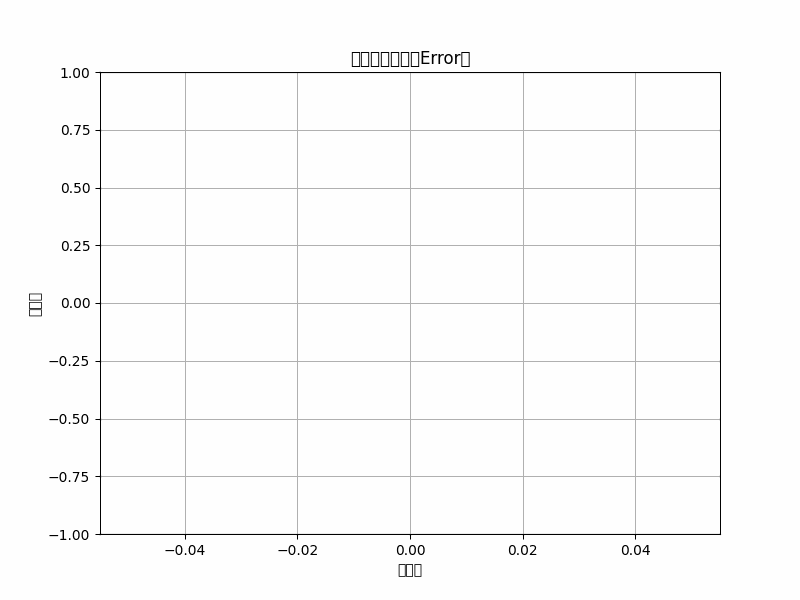

In [25]:
from IPython.display import Image

# 查看 Truth 动画
Image(filename='truth.gif')
# 查看 Model 动画
Image(filename='model.gif')
# 查看 Error 动画
Image(filename='error.gif')

